In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import pickle

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time

In [8]:
data = pd.read_csv('../data/data_with_features_v1.csv')
data.head()
data.shape

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,step_duration,mean_u_in,u_in_rolling_mean,u_in_rolling_sum,u_in_cum_sum,u_out_rolling_mean,u_out_rolling_sum,u_out_cum_sum,u_in_x_time_step,R_x_C
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.000000,10.146007,0.000000,0.000000,0.083334,0.0,0.0,0,0.000000,1000
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,0.033652,10.146007,9.233188,18.466375,18.466375,0.0,0.0,0,0.618632,1000
2,3,1,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,0.033862,10.146007,20.446160,40.892319,40.975653,0.0,0.0,0,1.519701,1000
3,4,1,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,0.034028,10.146007,22.659050,45.318100,63.784476,0.0,0.0,0,2.316059,1000
4,5,1,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,0.034213,10.146007,24.082336,48.164673,89.140326,0.0,0.0,0,3.442197,1000


(4522560, 20)

In [9]:
data['breath_id'].unique().shape

(56532,)

In [10]:
#train_test_split

train_breath_ids, test_breath_ids = train_test_split(data['breath_id'].unique(), test_size=0.4, random_state=0)

train = data[data['breath_id'].isin(train_breath_ids)]
test = data[data['breath_id'].isin(test_breath_ids)]

assert(data.shape[0] == train.shape[0] + test.shape[0])

In [11]:
#creating features and target
x_train = train.drop(columns = ['id', 'breath_id', 'pressure'])
y_train = train['pressure']
x_test = test.drop(columns = ['id', 'breath_id', 'pressure'])
y_test = test['pressure'] 

In [14]:
%%time

# Random Forest Model with parameters that gave a 0.786 R2 score in the basic model

rf_v1 = RandomForestRegressor(n_estimators=80, min_samples_split=5, max_features='log2', max_depth=21, n_jobs = -1)
rf_v1.fit(x_train, y_train)

CPU times: user 28min 36s, sys: 14.5 s, total: 28min 50s
Wall time: 8min 5s


RandomForestRegressor(max_depth=21, max_features='log2', min_samples_split=5,
                      n_estimators=80, n_jobs=-1)

In [18]:
#rf_v1 performance

print(f'training score: {rf_v1.score(x_train,y_train)}')
print(f'rf_v1 train mean absolute error: {mean_absolute_error(y_train, rf_v1.predict(x_train))}')

preds_rf_v1 = rf_v1.predict(x_test)

print(f'rf_v1 mean absolute error: {mean_absolute_error(y_test, preds_rf_v1)}')
print(f'rf_v1 rmse: {mean_squared_error(y_test, preds_rf_v1, squared=False)}')

training score: 0.9934102626332331
rf_v1 train mean absolute error: 0.3658288968567603
rf_v1 mean absolute error: 0.487670315565796
rf_v1 rmse: 0.9174024416901989


In [19]:
#exporting rf_v1

# pickle.dump(rf_v1, open('../models/rf_v1.p', 'wb'))

In [21]:
%%time

#gradient boosting to try and reduce the bias 

gb_v1 = GradientBoostingRegressor(min_samples_split=5, max_features='log2', max_depth=21, n_iter_no_change=10)
gb_v1.fit(x_train, y_train)

CPU times: user 38min 22s, sys: 2.03 s, total: 38min 24s
Wall time: 38min 25s


GradientBoostingRegressor(max_depth=21, max_features='log2',
                          min_samples_split=5, n_iter_no_change=10)

In [22]:
#gb_v1 performance

print(f'training score: {gb_v1.score(x_train,y_train)}')
print(f'gb_v1 train mean absolute error: {mean_absolute_error(y_train, gb_v1.predict(x_train))}')

preds_gb_v1 = gb_v1.predict(x_test)

print(f'gb_v1 mean absolute error: {mean_absolute_error(y_test, preds_gb_v1)}')
print(f'gb_v1 rmse: {mean_squared_error(y_test, preds_gb_v1, squared=False)}')

training score: 0.9986655423925048
gb_v1 train mean absolute error: 0.1445427240890014
gb_v1 mean absolute error: 0.44928703528395914
gb_v1 rmse: 0.8682519301362689


In [23]:
#exporting gb_v1

pickle.dump(gb_v1, open('../models/gb_v1.p', 'wb'))

In [26]:
rf_v1_feature_importances = pd.DataFrame({'feature': x_train.columns, 'feature_importance': rf_v1.feature_importances_})
rf_v1_feature_importances.sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
2,time_step,0.179944
11,u_in_cum_sum,0.174905
14,u_out_cum_sum,0.141713
8,mean_u_in,0.077158
13,u_out_rolling_sum,0.068956
6,u_in_lag_2,0.064424
12,u_out_rolling_mean,0.053622
1,C,0.033115
9,u_in_rolling_mean,0.031306
0,R,0.029694


count    56532.000000
mean         5.816341
std          0.995341
min          0.002414
25%          5.485981
50%          6.189002
75%          6.399909
max          7.454441
Name: pressure, dtype: float64

count    4.522560e+06
mean     1.123612e+01
std      8.110156e+00
min      2.413633e-03
25%      6.329607e+00
50%      7.032628e+00
75%      1.371133e+01
max      6.482099e+01
Name: pressure, dtype: float64

<AxesSubplot:>

<AxesSubplot:>

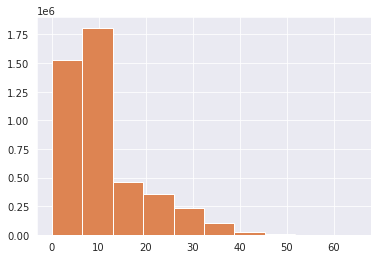

In [33]:
data[data['time_step']==0]['pressure'].describe()
data['pressure'].describe()
data[data['time_step']==0]['pressure'].hist()
data['pressure'].hist()

In [36]:
data[data['time_step']==0].groupby(['R','C'])['pressure'].mean()
data.groupby(['R','C'])['pressure'].mean()

R   C 
5   10    5.817923
    20    6.029615
    50    5.943726
20  10    5.663758
    20    5.786167
    50    6.107017
50  10    5.004304
    20    6.094731
    50    6.379787
Name: pressure, dtype: float64

R   C 
5   10    11.686853
    20    11.179176
    50    10.207738
20  10    12.000706
    20    11.246284
    50    10.782574
50  10    10.953117
    20    12.103469
    50    11.346053
Name: pressure, dtype: float64

In [37]:
#feature selection

# helper functions to create features

def create_polynomial_features(data, col_1, i, col_2 = None, j = None):
    ''' creates a column which is equal to col_1^i * col_2*j'''
    df = data.copy()
    if col_2 == None:
        df[col_1 + f'^{i}'] = df[col_1]**i
    else:
        df[col_1 + f'^{i}*' + col_2 + f'^{j}'] = (df[col_1]**i)*(df[col_2]**j)
    return df

def create_breath_level_agg_feature(data, col, agg: str):
    df = data.copy()
    if agg == 'cumsum':
        df[col+'_cumsum'] = df[col].cumsum()
    if agg == 'mean': 
        df[col+'_mean'] = df[col].mean()
    
    return df

In [40]:
data.columns
rf_v1_feature_importances.sort_values(by='feature_importance', ascending=False)

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'u_in_lag_1', 'u_in_lag_2', 'step_duration', 'mean_u_in',
       'u_in_rolling_mean', 'u_in_rolling_sum', 'u_in_cum_sum',
       'u_out_rolling_mean', 'u_out_rolling_sum', 'u_out_cum_sum',
       'u_in_x_time_step', 'R_x_C'],
      dtype='object')

,feature,feature_importance
2,time_step,0.179944
11,u_in_cum_sum,0.174905
14,u_out_cum_sum,0.141713
8,mean_u_in,0.077158
13,u_out_rolling_sum,0.068956
6,u_in_lag_2,0.064424
12,u_out_rolling_mean,0.053622
1,C,0.033115
9,u_in_rolling_mean,0.031306
0,R,0.029694


In [43]:
data = create_breath_level_agg_feature(data, 'u_in_x_time_step', 'mean')
data = create_breath_level_agg_feature(data, 'u_in_x_time_step', 'cumsum')

In [57]:
%%time

col_1 = 'u_in'
col_2 = 'time_step'
grid_i_j = np.linspace(1.25,3,8)

results = []

for i in grid_i_j:
    for j in grid_i_j:
        data_2 = create_polynomial_features(data, col_1, i, col_2, j )
        data_2 = create_breath_level_agg_feature(data_2, col_1 + f'^{i}*' + col_2 + f'^{j}', 'mean')
        data_2 = create_breath_level_agg_feature(data_2, col_1 + f'^{i}*' + col_2 + f'^{j}', 'cumsum')

        #train_test_split

        train_breath_ids, test_breath_ids = train_test_split(data['breath_id'].unique(), test_size=0.4, random_state=0)

        train = data_2[data_2['breath_id'].isin(train_breath_ids)]
        test = data_2[data_2['breath_id'].isin(test_breath_ids)]

        assert(data.shape[0] == train.shape[0] + test.shape[0])

        #creating features and target
        x_train = train.drop(columns = ['id', 'breath_id', 'pressure'])
        y_train = train['pressure']
        x_test = test.drop(columns = ['id', 'breath_id', 'pressure'])
        y_test = test['pressure'] 
        
        rf = RandomForestRegressor(n_estimators=80, min_samples_split=5, max_features='log2', max_depth=21, n_jobs = 3)
        rf.fit(x_train, y_train)
        preds = rf.predict(x_test)
        results.append(
            {'grid_params': (i,j), 
             'train_R2': rf.score(x_train, y_train), 
             'test_R2': r2_score(y_test, preds), 
             'test_mae': mean_absolute_error(y_test, preds)}        
                    ) 

CPU times: user 1d 8h 21min 4s, sys: 3min 34s, total: 1d 8h 24min 39s
Wall time: 11h 11min 1s


In [58]:
results
np.save('results.npy', results)

[{'grid_params': (1.25, 1.25),
  'train_R2': 0.9926914468241155,
  'test_R2': 0.9854990256060022,
  'test_mae': 0.5256409411574532},
 {'grid_params': (1.25, 1.5),
  'train_R2': 0.9927212903746244,
  'test_R2': 0.9855402162158913,
  'test_mae': 0.5247599846575208},
 {'grid_params': (1.25, 1.75),
  'train_R2': 0.9926952706243602,
  'test_R2': 0.9855508161885104,
  'test_mae': 0.5239837877091672},
 {'grid_params': (1.25, 2.0),
  'train_R2': 0.992737083405679,
  'test_R2': 0.9854923011273965,
  'test_mae': 0.5257287763959854},
 {'grid_params': (1.25, 2.25),
  'train_R2': 0.9927199735627802,
  'test_R2': 0.9855416766574252,
  'test_mae': 0.5240411486187455},
 {'grid_params': (1.25, 2.5),
  'train_R2': 0.9928292311050628,
  'test_R2': 0.9856162934340236,
  'test_mae': 0.523611441847861},
 {'grid_params': (1.25, 2.75),
  'train_R2': 0.9926772676795975,
  'test_R2': 0.9855513433498662,
  'test_mae': 0.5242576776996174},
 {'grid_params': (1.25, 3.0),
  'train_R2': 0.9928232896401302,
  'test_R2

In [61]:
rf.score(x_test,y_test)
x_train.columns

0.9855035207459574

Index(['R', 'C', 'time_step', 'u_in', 'u_out', 'u_in_lag_1', 'u_in_lag_2',
       'step_duration', 'mean_u_in', 'u_in_rolling_mean', 'u_in_rolling_sum',
       'u_in_cum_sum', 'u_out_rolling_mean', 'u_out_rolling_sum',
       'u_out_cum_sum', 'u_in_x_time_step', 'R_x_C', 'u_in_x_time_step_mean',
       'u_in_x_time_step_cumsum', 'u_in^3.0*time_step^3.0',
       'u_in^3.0*time_step^3.0_mean', 'u_in^3.0*time_step^3.0_cumsum'],
      dtype='object')

In [63]:
rf_feature_importances = pd.DataFrame({'feature': x_train.columns, 'feature_importance': rf.feature_importances_})
rf_feature_importances.sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
11,u_in_cum_sum,0.162013
14,u_out_cum_sum,0.145066
2,time_step,0.116335
8,mean_u_in,0.078481
13,u_out_rolling_sum,0.078329
6,u_in_lag_2,0.069416
12,u_out_rolling_mean,0.064283
9,u_in_rolling_mean,0.037030
5,u_in_lag_1,0.032579
1,C,0.031963
